In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

We want to solve the [heat equation](https://en.wikipedia.org/wiki/Heat_equation)

$$
u_{t} = a^2 u_{xx}
$$

So we think of having a 1-dimensional function $u(x)$.
Its Fourier transform we denote as $\hat{u}(\kappa)$. 
The second derivative with respect to position, $x$, brings down two times the factor $i\kappa$, so $(i\kappa)^2=-\kappa^2$. 
Consequently if we apply the Fourier transform to both sides of our equation we arrive at

$$
{d\hat{u}(\kappa) \over dt} =  - a^2 \kappa^2 \hat{u}(\kappa).
$$

Wow. This says that the Fourier coefficients all just decay with $a^2\kappa^2$ exponentially. 
This is exactly why Fourier worked on this and how he managed to solve this equation. 
So in principle we would not have to do this numerically but we use this as our first example to demonstrate how this solution strategy is implemented in code. 
Once we know this we can "graduate" to use a similar strategy for more complex equations. 

In [12]:
a = 0.01    # Thermal diffusivity constant
L = 2  # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 1.
t = np.arange(0,100,dt)

def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -a**2 * kappa**2 * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args=(kappa,a))

uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])

u = u.real    

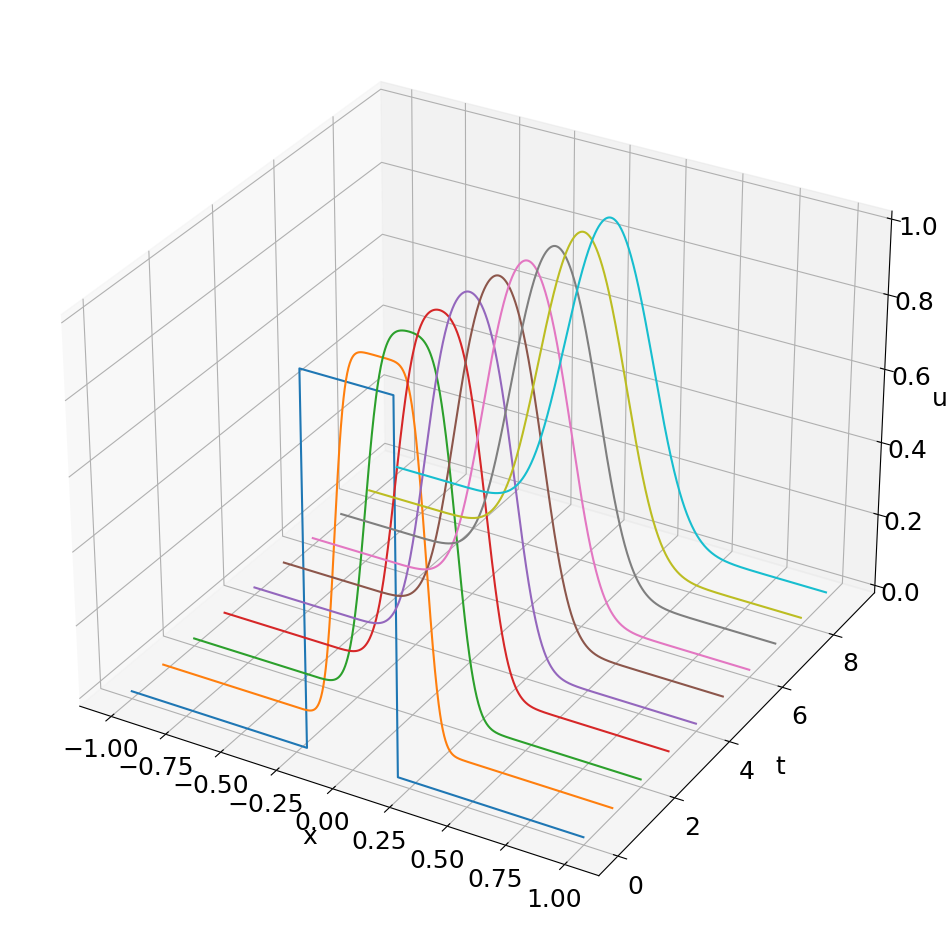

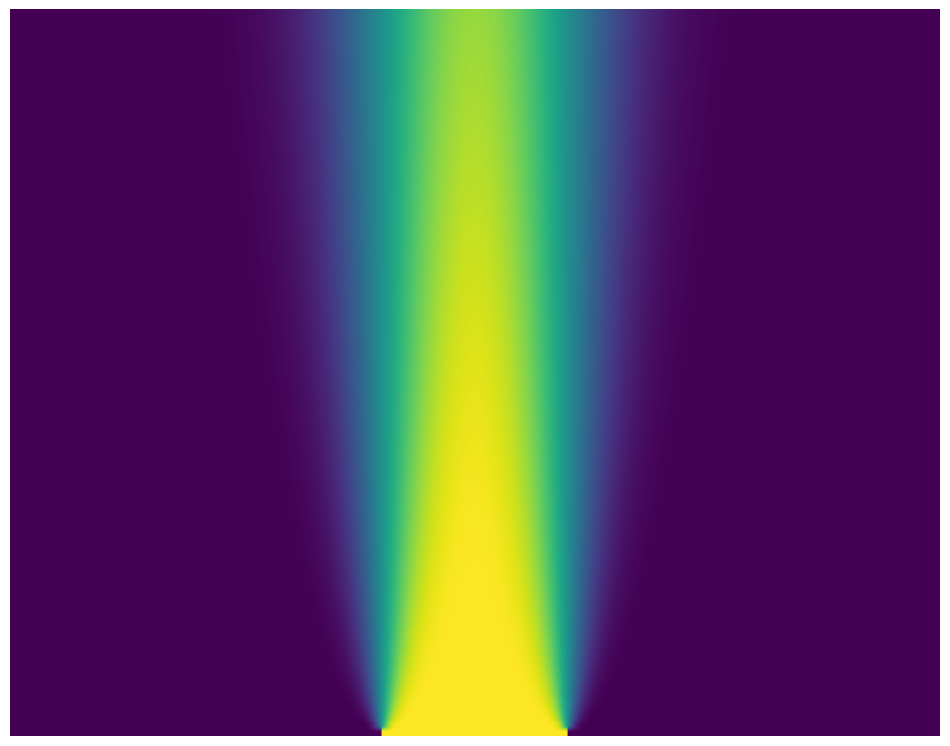

In [13]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("u")
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8)
plt.axis('off')

plt.show()

In [14]:
u.sum(axis=1)

array([205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205., 205., 205., 205., 205., 205., 205., 205., 205., 205., 205.,
       205.])

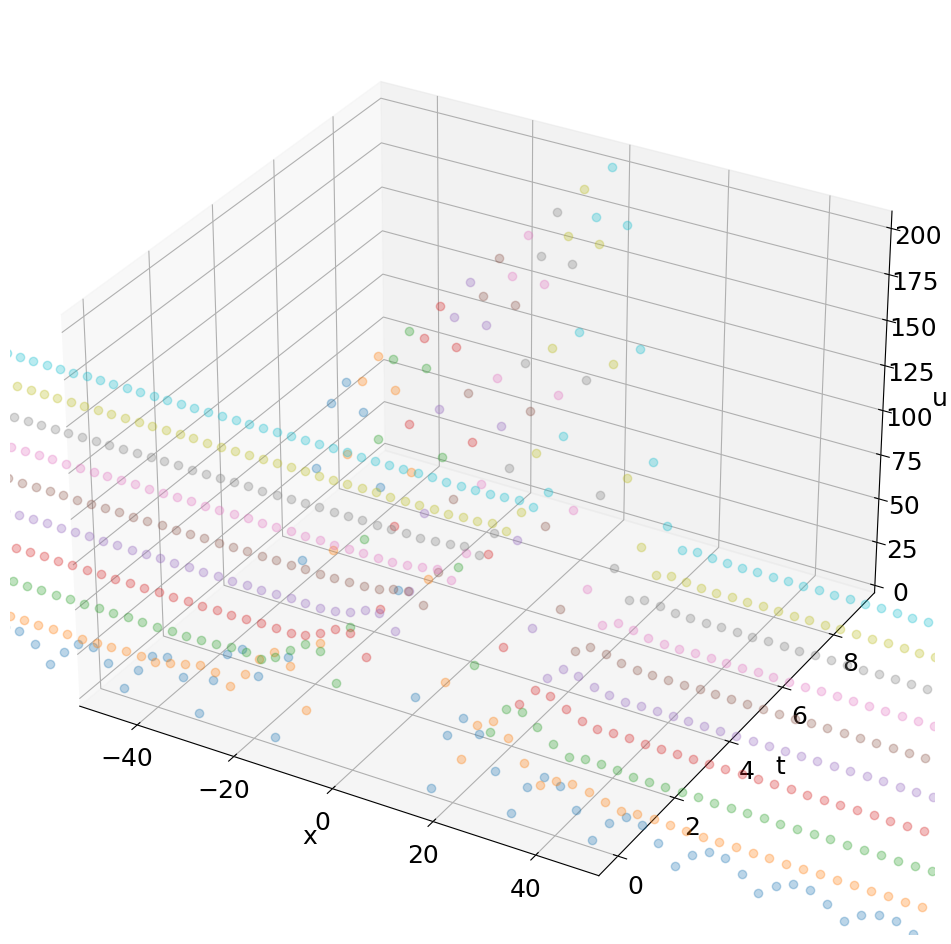

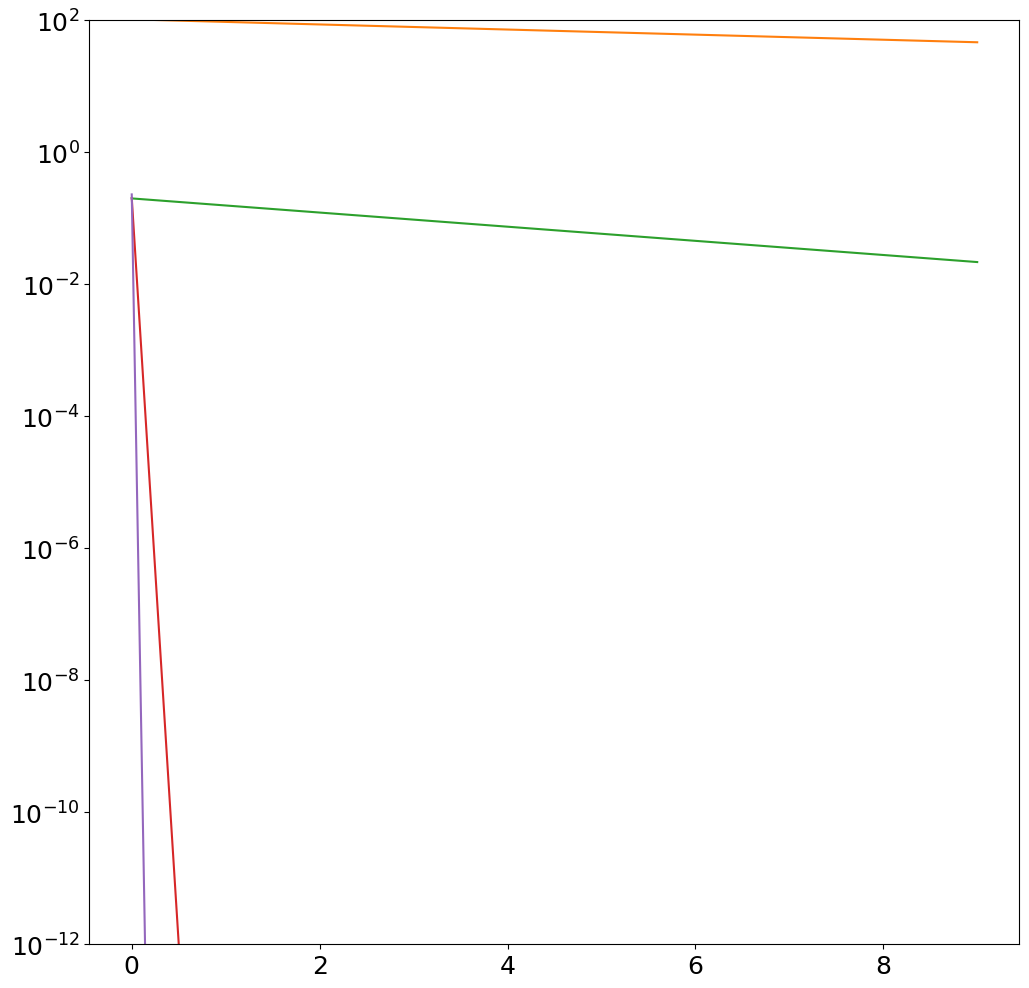

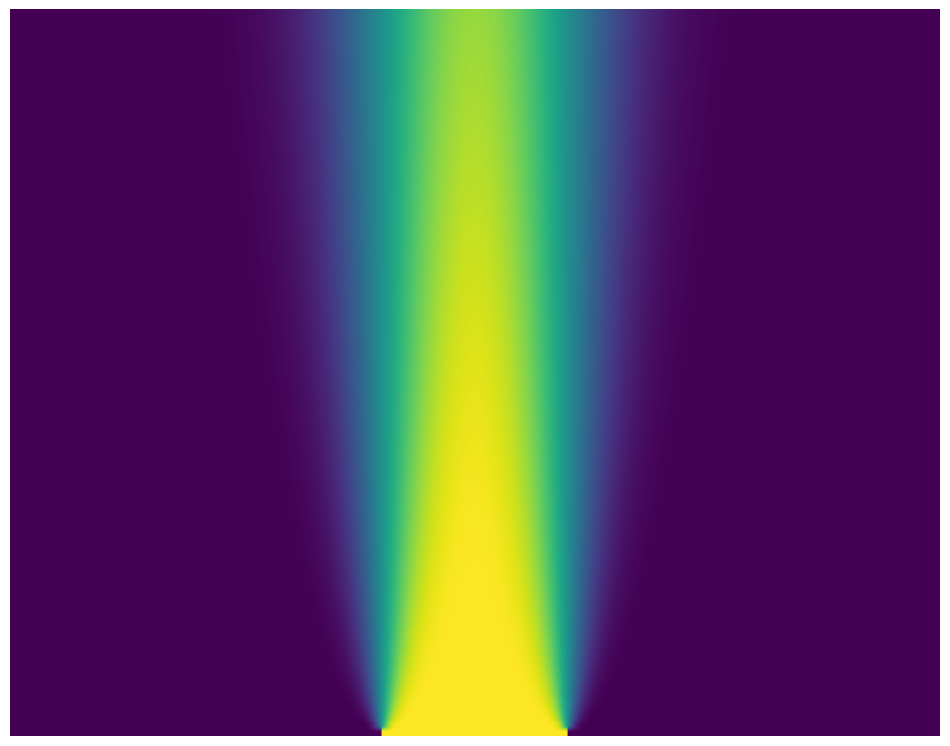

In [15]:
# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = np.abs(uhat[0:-1:10,:])
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(kappa,ys,u_plot[j,:],'o',alpha=.3)
plt.xlabel("x")
plt.ylabel("t")
ax.set_zlabel("u")
plt.xlim(-50,50)

fig = plt.figure()

plt.semilogy(range(len(u_plot[:,1])), u_plot[:,1],label="k=1")
plt.plot(range(len(u_plot[:,3])), u_plot[:,3],label="k=1")
plt.plot(range(len(u_plot[:,5])), u_plot[:,5],label="k=1")
plt.plot(range(len(u_plot[:,100])), u_plot[:,100],label="k=1")
plt.plot(range(len(u_plot[:,300])), u_plot[:,300],label="k=1")

plt.ylim(1e-12,1e2)
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8)
plt.axis('off')

plt.show()

Now let's try a propagating wave equation:
$$
u_t - c u_x = 0
$$
which looks like
$$
{d \hat{u}(\kappa) \over dt} = c {du(x) \over dx} = - i\kappa\, c\, \hat{u}(\kappa)
$$
after Fourier transform.

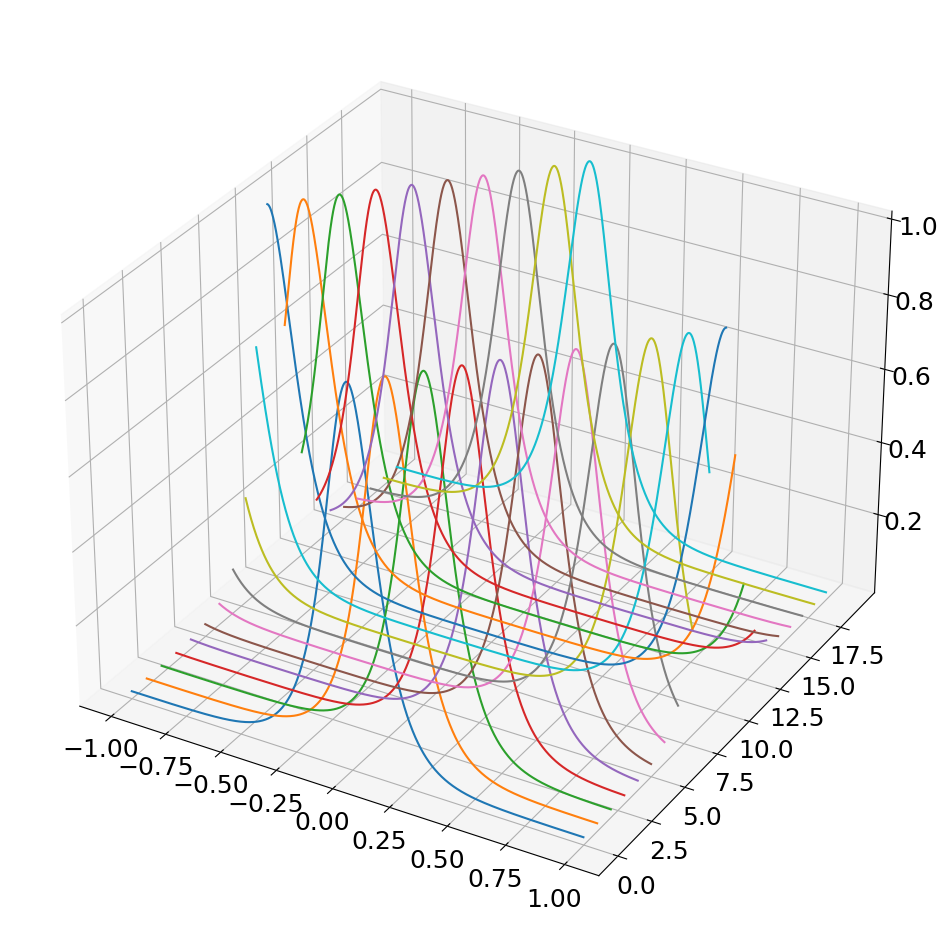

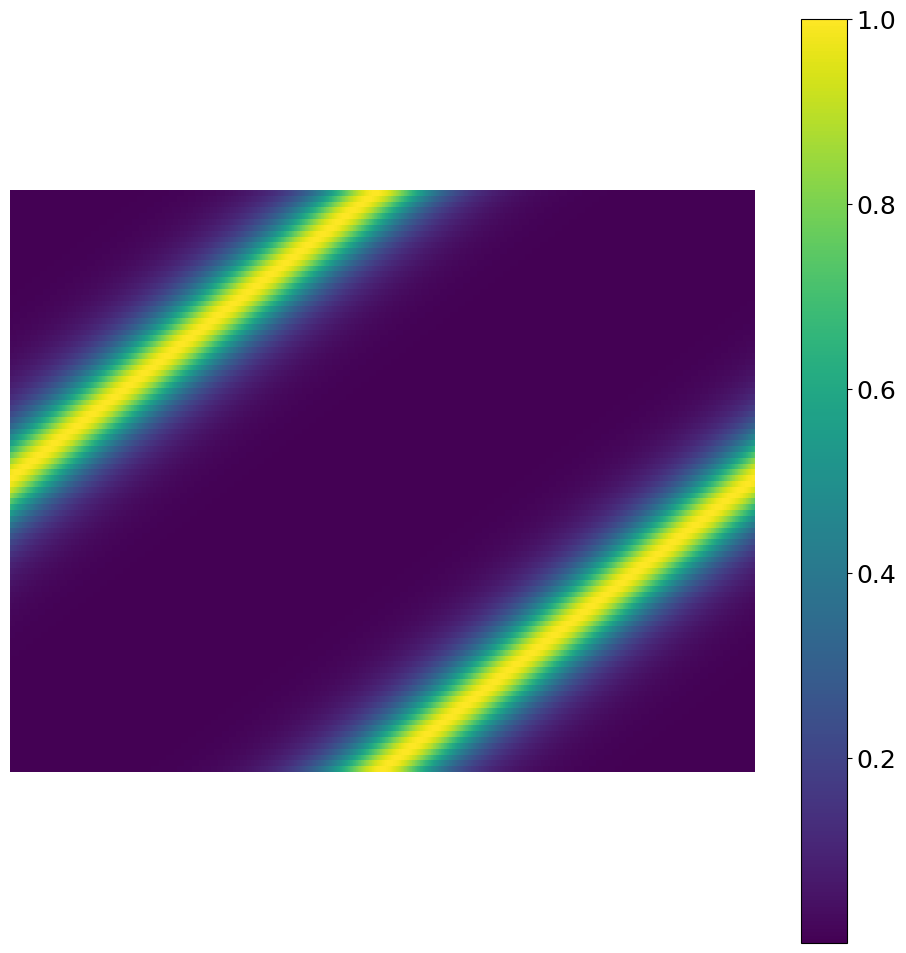

In [9]:

c = 2    # Wave speed
L = 2   # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.01
t = np.arange(0,100*dt,dt)

def rhsWave(uhat_ri,t,kappa,c):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[N:]
    d_uhat = -c*(1j)*kappa*uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsWave, u0hat_ri, t, args=(kappa,c))
uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]

# Alternatively, simulate in spatial domain
def rhsWaveSpatial(u,t,kappa,c):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real
    du_dt = -c*d_u
    return du_dt

u = odeint(rhsWaveSpatial,u0,t,args=(kappa,c))

# Inverse FFT to bring back to spatial domain
#u = np.zeros_like(uhat)

#for k in range(len(t)):
#    u[k,:] = np.fft.ifft(uhat[k,:])

#u = u.real   

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:5,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
    
# Image plot
plt.figure()
plt.imshow(np.flipud(u), aspect=8, interpolation="none")
plt.colorbar()
plt.axis('off')
plt.show()

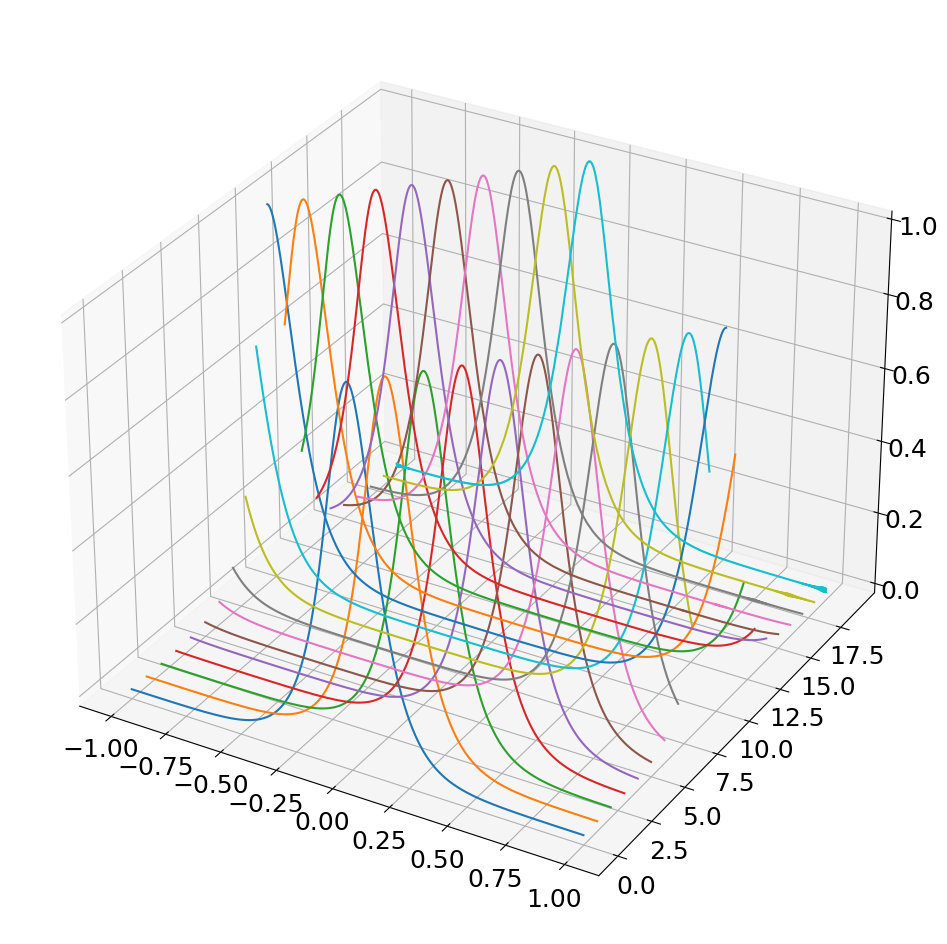

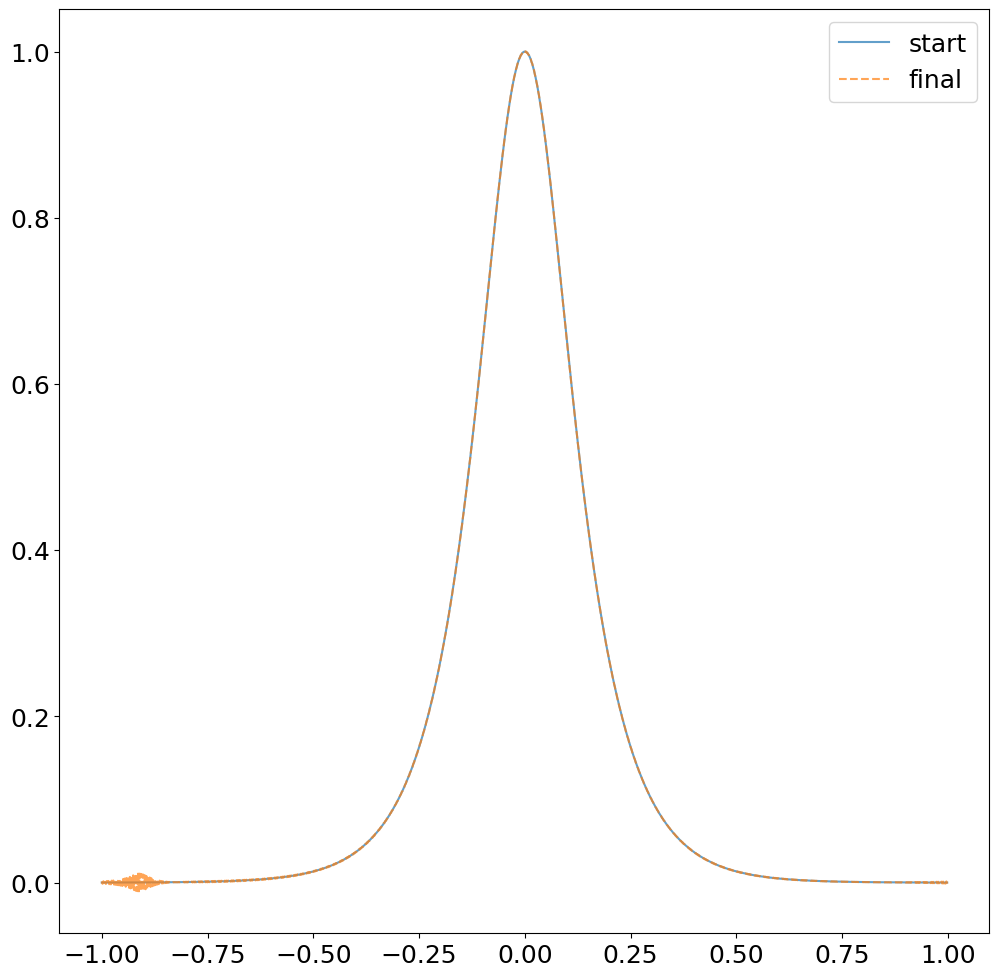

In [10]:
c = 2    # Wave speed
L = 2   # Length of domain
N = 1024 # Number of discretization points
dx = L/N
x = np.arange(-L/2,L/2,dx) # Define x domain

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

# Initial condition
u0 = 1/np.cosh(x/(L/20))
u0hat = np.fft.fft(u0)

# SciPy's odeint function doesn't play well with complex numbers, so we recast 
# the state u0hat from an N-element complex vector to a 2N-element real vector
u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

# Simulate in Fourier frequency domain
dt = 0.01
t = np.arange(0,101*dt,dt)

# Alternatively, simulate in spatial domain
def rhsWaveSpatial(u,t,kappa,c):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat).real
    du_dt = -c*d_u
    return du_dt

u = np.zeros((len(t),N))
u[0,:] = u0
for i in range(1,len(t)):
#u = odeint(rhsWaveSpatial,u0,t,args=(kappa,c)) 
    u_old = u [i-1,:] 
    u_new = u_old.copy()
    Ns = 100
    for j in range(Ns): # substepping
        uint = u_old + dt/2/Ns*rhsWaveSpatial(u_old,t, kappa,c)
        u_new = u_old + dt/Ns*rhsWaveSpatial(uint,t, kappa,c)
        u_old = u_new
    u[i,:] = u_new
# Inverse FFT to bring back to spatial domain
#u = np.zeros_like(uhat)

#for k in range(len(t)):
#    u[k,:] = np.fft.ifft(uhat[k,:])

u = u.real   

# Waterfall plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u_plot = u[0:-1:5,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])

fig2 = plt.figure()
plt.plot(x, u[0,:],alpha=0.7,label="start")
plt.plot(x, u[-1,:],"--",alpha=0.7,label="final")
plt.legend();
